In [16]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.stats
from operator import itemgetter

In [3]:
def sliding_window(image, stepSize, windowSize):
  for y in range(0, image.shape[0], stepSize):
    for x in range(0, image.shape[1], stepSize):
      yield(x,y,image[y:y+windowSize[1],x:x+windowSize[0]])

In [29]:
MEAN = 'mean'
VARIANCE = 'variance'
SKEWNESS = 'skew'
KURTOSIS = 'kurt'
ENTROPY  = 'entropy'
ENERGY   = 'energy'

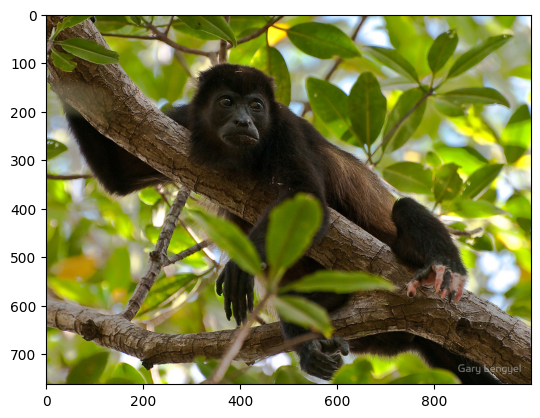

In [4]:
img = plt.imread('./monos/n0114.jpg')
plt.imshow(img)

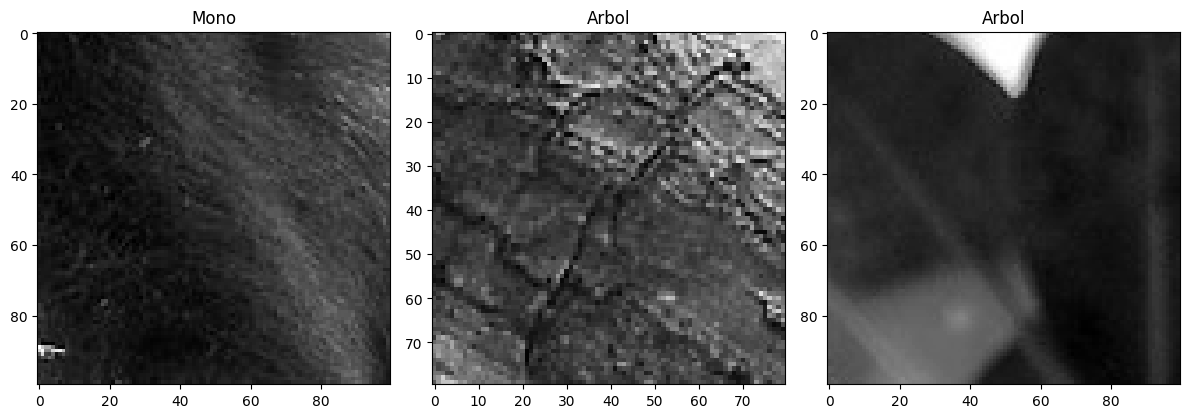

In [6]:
texel_mono  = cv2.cvtColor(img[260:360,480:580],cv2.COLOR_RGB2GRAY)
texel_arbol = cv2.cvtColor(img[190:270,150:230],cv2.COLOR_RGB2GRAY)

texel_hoja  = cv2.cvtColor(img[150:250,570:670],cv2.COLOR_RGB2GRAY)

fig,axes = plt.subplots(1,3,figsize=(12,4))
ax = axes.ravel()
ax[0].imshow(texel_mono, cmap=plt.cm.gray)
ax[0].set_title("Mono")
ax[1].imshow(texel_arbol, cmap=plt.cm.gray)
ax[1].set_title("Arbol")
ax[2].imshow(texel_hoja, cmap=plt.cm.gray)
ax[2].set_title("Arbol")
fig.tight_layout()
plt.show()


In [7]:
def getEnergy(image):
  energy = 0
  for x in range(image.shape[0]):
    for y in range(image.shape[1]):
      energy += (image[x,y])**2
  return energy
  

In [18]:
from scipy.stats import skew,kurtosis,entropy

def getFirstOrderStatistics(image: np.ndarray,names=False,stats_list: list = []):
  
  stats = {
    'mean': image.mean(),
    'variance': image.var(),
    'skew': skew(image,axis=(0,1)),
    'kurt': kurtosis(image,axis=(0,1)),
    'entropy': entropy(image,axis=(0,1)),
    'energy': getEnergy(image)
  }

  if len(stats_list) > 0:
    return list(itemgetter(*stats_list)(stats))
  return stats if names else list(stats.values())

In [19]:
def getTrainingData(texel: np.ndarray, step=10,windowSz=(10,10),stats_list=[]):
  data = []
  for (x,y,window) in sliding_window(texel,stepSize=step,windowSize=windowSz):
    data.append(getFirstOrderStatistics(window,stats_list=stats_list))
  return np.array(data)



In [20]:
tree_data = getTrainingData(texel_arbol)
mono_data = getTrainingData(texel_mono)
hoja_data = getTrainingData(texel_hoja)

In [22]:
def getAllTrainingData(tree_data,mono_data,hoja_data):
  train_data = np.append(tree_data,mono_data,0)
  train_data = np.append(train_data,hoja_data,0)

  # 0 arbol
  # 1 mono
  # 2 hojas
  train_labels = np.zeros(train_data.shape[0])
  train_labels[tree_data.shape[0]:tree_data.shape[0]+mono_data.shape[0]] = 1
  train_labels[tree_data.shape[0]+mono_data.shape[0] :tree_data.shape[0]+mono_data.shape[0]+hoja_data.shape[0]] = 2
  
  return (train_data,train_labels)


In [23]:

from sklearn.naive_bayes import GaussianNB


train_data, train_labels = getAllTrainingData(tree_data,mono_data,hoja_data)


gnb = GaussianNB()
gnb.fit(train_data,train_labels)


GaussianNB()

In [26]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(train_data,train_labels)


KNeighborsClassifier()

In [25]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(train_data)

In [42]:
def classificadorBayesiano(imagen:np.ndarray,gnb = gnb,windowSize=(10,10),windowStep=10,stats_list=[]):
  color = [[79, 131, 176],[133, 65, 181],[217, 210, 17]]
  cont_err_win = 0
  cont_err_nan = 0
  res = np.zeros(shape=imagen.shape)
  res = np.dstack([res,res,res])
  
  for(x,y,window) in sliding_window(imagen,windowStep,windowSize):
    
    if window.shape[0] != windowSize[0] or window.shape[1] != windowSize[1]:
      cont_err_win += 1
      continue
    
    
    vector = getFirstOrderStatistics(window,stats_list=stats_list)

    if np.isnan(vector).any():
      cont_err_nan += 1
      continue
    
    color_prediction = color[int(gnb.predict([vector]))]
    for iy in range(y,y+10):
      for ix in range(x,x+10):
        if (ix < res.shape[1] and iy < res.shape[0]):
          res[iy,ix] = color_prediction
    
  return res

In [41]:
def kmeansClassifier(imagen:np.ndarray,windowSize=(10,10),windowStep=10,stats_list=[]):
  color = [[79, 131, 176],[133, 65, 181],[217, 210, 17]]
  cont_err_win = 0
  cont_err_nan = 0
  res = np.zeros(shape=imagen.shape)
  res = np.dstack([res,res,res])
  
  for(x,y,window) in sliding_window(imagen,windowStep,windowSize):
    
    if window.shape[0] != windowSize[0] or window.shape[1] != windowSize[1]:
      cont_err_win += 1
      continue
    
    
    vector = getFirstOrderStatistics(window,stats_list=stats_list)

    if np.isnan(vector).any():
      cont_err_nan += 1
      continue
    
    color_prediction = color[int(kmeans.predict([vector]))]
    for iy in range(y,y+10):
      for ix in range(x,x+10):
        if (ix < res.shape[1] and iy < res.shape[0]):
          res[iy,ix] = color_prediction
    
  return res

In [40]:
def neighborsClassifier(imagen:np.ndarray,windowSize=(10,10),windowStep=10,stats_list=[]):
  color = [[79, 131, 176],[133, 65, 181],[217, 210, 17]]
  cont_err_win = 0
  cont_err_nan = 0
  res = np.zeros(shape=imagen.shape)
  res = np.dstack([res,res,res])
  
  for(x,y,window) in sliding_window(imagen,windowStep,windowSize):
    
    if window.shape[0] != windowSize[0] or window.shape[1] != windowSize[1]:
      cont_err_win += 1
      continue
    
    
    vector = getFirstOrderStatistics(window,stats_list=stats_list)

    if np.isnan(vector).any():
      cont_err_nan += 1
      continue
    
    color_prediction = color[int(neigh.predict([vector]))]
    for iy in range(y,y+10):
      for ix in range(x,x+10):
        if (ix < res.shape[1] and iy < res.shape[0]):
          res[iy,ix] = color_prediction
    
  return res

C:\Users\kart-\AppData\Local\Temp\ipykernel_7796\1032886762.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(image,axis=(0,1)),
C:\Users\kart-\AppData\Local\Temp\ipykernel_7796\1032886762.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(image,axis=(0,1)),
C:\Users\kart-\AppData\Local\Temp\ipykernel_7796\1032886762.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(image,axis=(0,1)),
C:\Users\kart-\AppData\Local\Temp\ipykernel_7796\1032886762.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the 

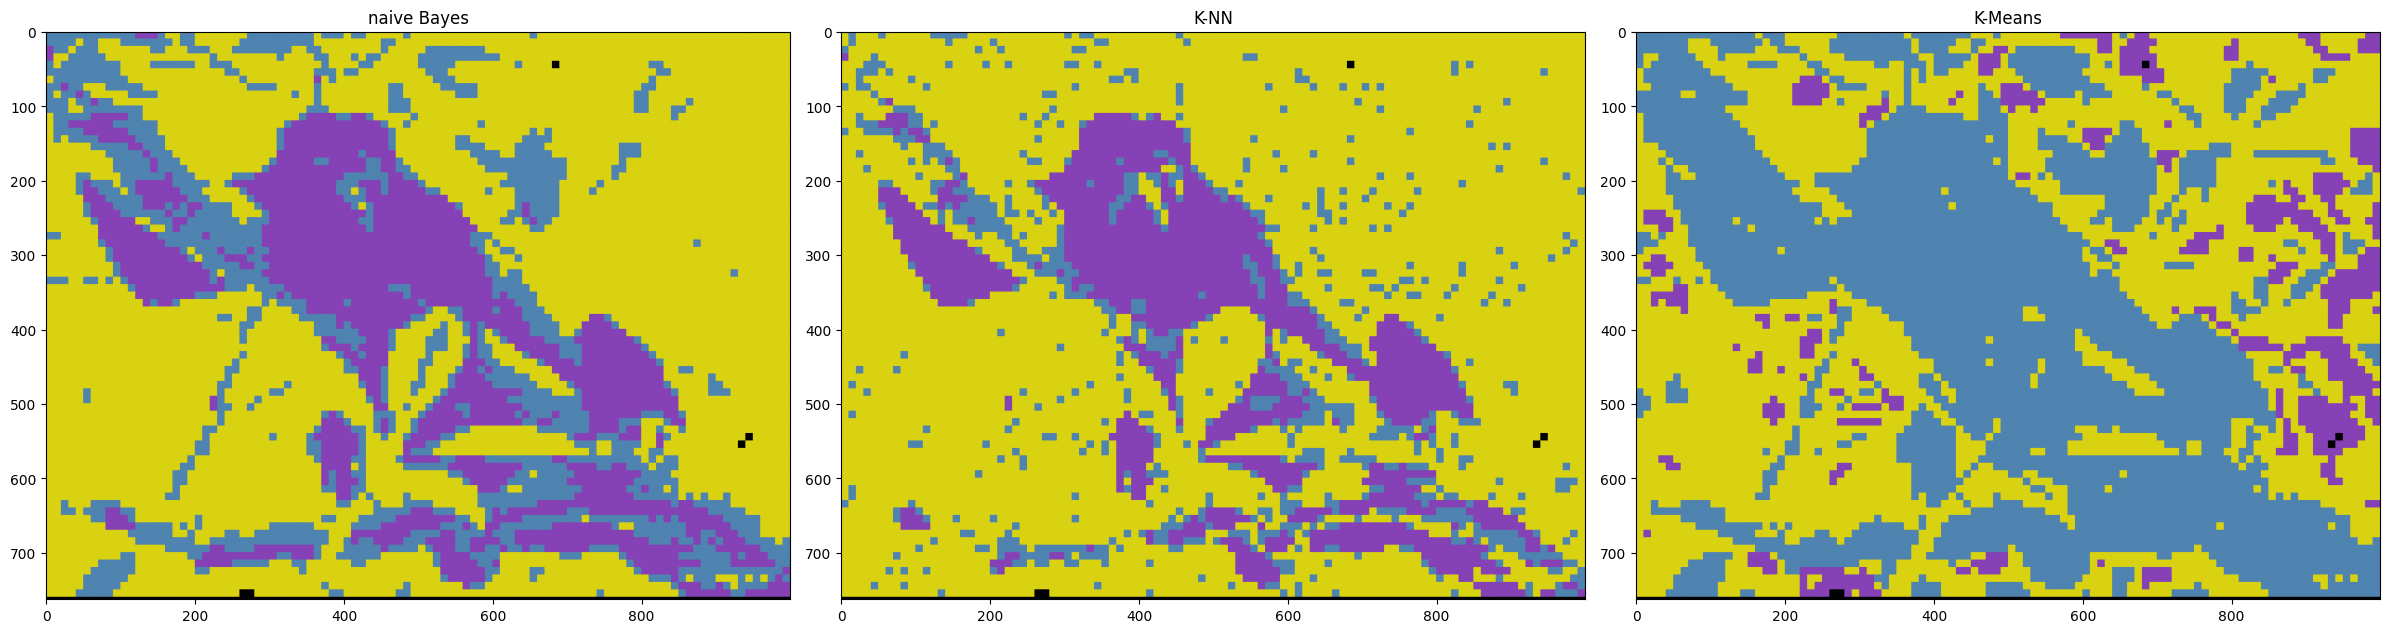

In [55]:
mono1 = cv2.imread('./monos/n0114.jpg')
mono1 = cv2.cvtColor(mono1,cv2.COLOR_BGR2GRAY)

mono1_class = classificadorBayesiano(mono1)
mono2_class = neighborsClassifier(mono1)
mono3_class = kmeansClassifier(mono1)

fig,axes = plt.subplots(1,3,figsize=(24,8))
ax = axes.ravel()
ax[0].imshow(mono1_class/255)
ax[0].set_title("naive Bayes")
ax[1].imshow(mono2_class/255)
ax[1].set_title("K-NN")
ax[2].imshow(mono3_class/255)
ax[2].set_title("K-Means")
fig.tight_layout()
plt.show()


## Clasificador usando diferentes estadísticos

In [57]:
stats1 = [MEAN,VARIANCE,KURTOSIS,ENTROPY]

mono_data_prueba1  = getTrainingData(texel_mono,stats_list=stats1)
arbol_data_prueba1 = getTrainingData(texel_arbol,stats_list=stats1)
hojas_data_prueba1 = getTrainingData(texel_hoja,stats_list=stats1)

In [58]:
train_data_prueba1, train_labels_prueba1 = getAllTrainingData(arbol_data_prueba1,mono_data_prueba1,hojas_data_prueba1)

gnb_prueba1 = GaussianNB()
gnb_prueba1.fit(train_data_prueba1,train_labels_prueba1)

GaussianNB()

In [59]:
mono_prueba1 = cv2.imread('./monos/n0114.jpg')
mono_prueba1 = cv2.cvtColor(mono_prueba1,cv2.COLOR_BGR2GRAY)

mono_prueba1_class = classificadorBayesiano(mono_prueba1, gnb=gnb_prueba1,stats_list=stats1)

C:\Users\kart-\AppData\Local\Temp\ipykernel_7796\1032886762.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(image,axis=(0,1)),
C:\Users\kart-\AppData\Local\Temp\ipykernel_7796\1032886762.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(image,axis=(0,1)),
C:\Users\kart-\AppData\Local\Temp\ipykernel_7796\1032886762.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(image,axis=(0,1)),
C:\Users\kart-\AppData\Local\Temp\ipykernel_7796\1032886762.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the 

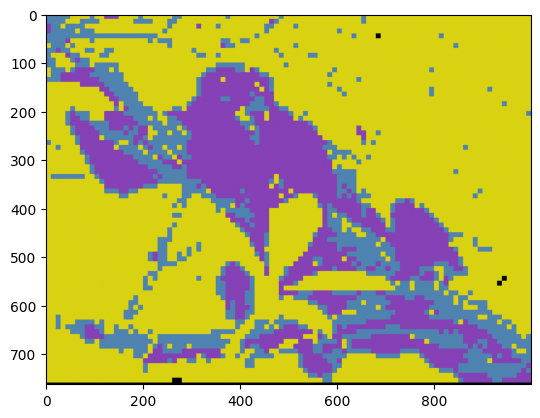

In [60]:
plt.imshow(mono_prueba1_class/255)

## Variando el tamaño de la ventana

In [79]:
winSz  = (5,5)
stepSz = 5

mono_data_prueba2  = getTrainingData(texel_mono,windowSz=winSz,step=stepSz)
arbol_data_prueba2 = getTrainingData(texel_arbol,windowSz=winSz,step=stepSz)
hojas_data_prueba2 = getTrainingData(texel_hoja,windowSz=winSz,step=stepSz) 

In [80]:
train_data_prueba2, train_labels_prueba2 = getAllTrainingData(arbol_data_prueba2,mono_data_prueba2,hojas_data_prueba2)

gnb_prueba2 = GaussianNB()
gnb_prueba2.fit(train_data_prueba2,train_labels_prueba2)

GaussianNB()

In [83]:
mono_prueba2 = cv2.imread('./monos/n0035.jpg')
mono_prueba2 = cv2.cvtColor(mono_prueba2,cv2.COLOR_BGR2GRAY)

mono_prueba2_class = classificadorBayesiano(mono_prueba2, gnb=gnb_prueba2,windowSize=winSz,windowStep=stepSz)

C:\Users\kart-\AppData\Local\Temp\ipykernel_7796\1032886762.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(image,axis=(0,1)),
C:\Users\kart-\AppData\Local\Temp\ipykernel_7796\1032886762.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(image,axis=(0,1)),
C:\Users\kart-\AppData\Local\Temp\ipykernel_7796\1032886762.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(image,axis=(0,1)),
C:\Users\kart-\AppData\Local\Temp\ipykernel_7796\1032886762.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the 

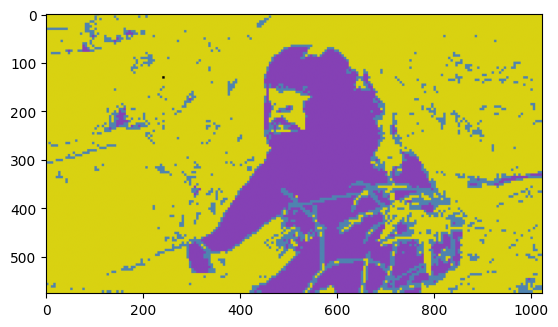

In [84]:
plt.imshow(mono_prueba2_class/255)